**Dataset**

The dataset is built by us locally. It consist of six records, each one sec length.
Only two classes "ليه" and "يعنى", which are two commonly used in Egyptian arabic. One of the records are reserved for testing.

Let's start by importing all the libraries that we will need

In [192]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
import wave
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model

warnings.filterwarnings("ignore")

Checking the sampling rate

In [199]:
train_audio_path = './data/train/'
wave_file = wave.open(train_audio_path+'ya3ni/ya3ni.wav', "rb") 
sample_rate = wave_file.getframerate()

In [198]:
print('sample rate is ', sample_rate, ' Hz')

sample rate is  22050  Hz


**Data Exploration and Visualization**

Data Exploration and Visualization helps us to understand the data as well as pre-processing steps in a better way. 

**Visualization of Audio signal in time series domain**

Now, we’ll visualize the audio signal in the time series domain:

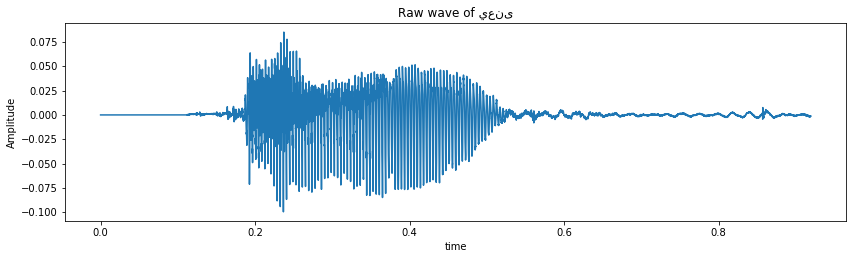

In [200]:
samples, sample_rate = librosa.load(train_audio_path+'ya3ni/ya3ni.wav',sr=16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of يعنى')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)

Now, let’s understand the number of recordings for each voice command:

In [201]:
labels=os.listdir(train_audio_path)
labels

['ya3ni', 'ليه']

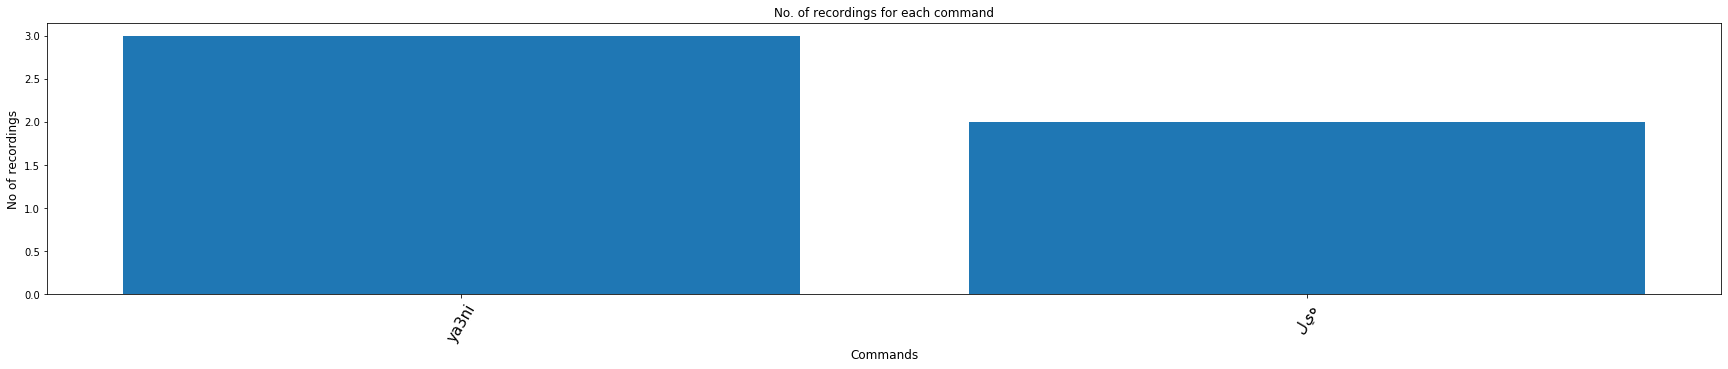

In [202]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

**Preprocessing the audio waves**
* Resampling

    From the above, we can understand that the sampling rate of the signal is 16000 hz. The most important frequencies for speech and language are between 250 and 8,000 Hz.
    Let us resample it to 8000 hz since most of the speech related frequencies are present in 8000z 

* Making sure that all waves are equal in length(i.e only 8000 sample after the resampling)

In [204]:
all_wave = []
all_label = []
for label in labels:
    #print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        #print(wav)
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 8000)
        #mel_wave = librosa.feature.melspectrogram(y=samples, sr=8000)
        #duration_of_recordings=(float(len(samples)/sample_rate))
        #print(duration_of_recordings)
        #print(len(samples))
        #print(mel_wave.shape)
        
        all_wave.append(samples[:8000])
        all_label.append(label)

Convert the output labels to integer encoded:

In [205]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
classes

['ya3ni', 'ليه']

In [206]:
y

array([0, 0, 0, 1, 1], dtype=int64)

Reshape the list of arrays to 2D array:

In [137]:
all_wave = np.array(all_wave).reshape(-1,8000)
all_wave.shape

(5, 8000)

Getting the Mel spectrogram for feature extraction as Mel spectrograms are better suited for applications that need to model human hearing perception

In [138]:
mel_wave = librosa.feature.melspectrogram(y= all_wave, sr=8000)

In [139]:
mel_wave.shape

(5, 128, 16)

**Split into train and validation set**

Next, we will train the model on 70% of the data and validate on the remaining 30%:


In [158]:
x_tr, x_val, y_tr, y_val = train_test_split(mel_wave,np.array(y),stratify=y,test_size = 0.3,random_state=777,shuffle=True)

In [159]:
#checking the shape of each array
print(y_tr.shape)
print(y_val.shape)
print(x_tr.shape)
print(x_val.shape)

(3,)
(2,)
(3, 128, 16)
(2, 128, 16)


**Model Architecture for this problem**

We will build the speech-to-text model using one Conv1D for better feature extraction and LSTM for RNN layer. 
Please note that in the future to make this project run on conversations not only voice commands we will need to add more layers to enhance the performance and also we will need to add a language model and a rescoring model.

**Model building**


In [173]:

model = Sequential()

model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',
                        input_shape=(128, 16)))
model.add(MaxPooling1D(pool_size=4))

model.add(LSTM(64))

model.add(Dense(units=2, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metric])
# model.compile(optimizer="sgd", loss="mse", metrics=[metric])

print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 128, 256)          20736     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 32, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 103,042
Trainable params: 103,042
Non-trainable params: 0
_________________________________________________________________
None


Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:


In [184]:
history=model.fit(x_tr, y_tr ,epochs=1, batch_size=32, validation_data=(x_val,y_val))

1/1 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.33 - 0s 162ms/step - loss: 0.2776 - accuracy: 0.3333 - val_loss: 0.4156 - val_accuracy: 0.5000


**Testing**

In [189]:
def predict(audio):
    samples, sample_rate = librosa.load('./data/test/'+audio, sr = 8000)
    wave = np.array(samples[:8000]).reshape(-1,8000)
    prob = model.predict(librosa.feature.melspectrogram(y= wave, sr=8000))
    index=np.argmax(prob[0])
    return classes[index]

#print("Text:",predict(samples))

In [191]:
prop = predict('ya3ni.wav')
print(prop)


ليه


Since the accuracy is low, the predicted class is wrong